# Boosting - Diabetes Dataset

# Importamos las librerias a utilizar

In [1]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from imblearn.metrics import specificity_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import joblib

# 1.1 Importamos el dataframe limpio

In [2]:
df = pd.read_pickle('/workspaces/carlos060495-intro-ml/data/processed/diabetes_clean.pkl')

print("✅ Dataframe cargado exitosamente")
print(f"📊 Forma del dataframe: {df.shape}")
df.head()

✅ Dataframe cargado exitosamente
📊 Forma del dataframe: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.000000,218.922943,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.000000,70.302975,26.6,0.351,31.0,0
2,8.0,183.0,64.0,21.532622,268.502252,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.000000,168.000000,43.1,2.288,33.0,1


# 2.1 Train Test Split

In [3]:
# Separar características y variable objetivo
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo de Boosting con hiperparámetros mejorados
model = GradientBoostingClassifier(
    n_estimators=100,        # Más árboles para mejor aprendizaje
    learning_rate=0.1,       # Tasa de aprendizaje más razonable
    max_depth=3,             # Profundidad típica en boosting
    min_samples_leaf=5,      # Menos restrictivo
    random_state=42          # Para reproducibilidad
)
model.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [4]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [5]:
# Realizamos predicciones en el conjunto de entrenamiento y prueba
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

# Evaluamos el rendimiento del modelo
get_metrics(y_train, y_test, train_pred, test_pred)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.946254,0.919315,0.931339,0.959184,0.882629,0.980050
Test,0.759740,0.678261,0.748485,0.650000,0.709091,0.787879
Diferencia,0.186514,0.241055,0.182855,0.309184,0.173538,0.192171


# 3.1 Hiperparametros

In [6]:
# Espacio de búsqueda para GradientBoostingClassifier
param_grid = {
    'n_estimators': [100, 200],           
    'learning_rate': [0.05, 0.1],         
    'max_depth': [3, 4],                  
    'min_samples_split': [2, 5],          
    'min_samples_leaf': [1, 2],           
    'subsample': [0.8, 1.0]               
}


# GridSearchCV
grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',  # Métrica apropiada para clasificación
    cv=5,
    verbose=2,
    n_jobs=-1
)

print("🔍 Buscando los mejores hiperparámetros para Gradient Boosting...")

# Ajuste
grid_search.fit(X_train, y_train)

print("\n✅ Búsqueda completada!")
print("=" * 50)
print("🏆 MEJORES HIPERPARÁMETROS:")
print("=" * 50)
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")
print("=" * 50)
print(f"Mejor F1-Score (CV): {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

🔍 Buscando los mejores hiperparámetros para Gradient Boosting...
Fitting 5 folds for each of 64 candidates, totalling 320 fits


[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=3, min_samples_l

# 3.2 Evaluación del Modelo Optimizado

In [7]:
# Realizamos predicciones con el modelo optimizado
best_test_pred = best_model.predict(X_test)
best_train_pred = best_model.predict(X_train)

# Evaluamos el rendimiento del modelo optimizado
best_metrics = get_metrics(y_train, y_test, best_train_pred, best_test_pred)
print("📊 Métricas del Modelo Optimizado (GridSearchCV):")
print("=" * 60)
best_metrics

📊 Métricas del Modelo Optimizado (GridSearchCV):


,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.90228,0.854369,0.884467,0.884422,0.826291,0.942643
Test,0.74026,0.655172,0.729293,0.622951,0.690909,0.767677
Diferencia,0.16202,0.199197,0.155174,0.261471,0.135382,0.174967


# 3.3 Comparación: Modelo Base vs Modelo Optimizado

In [8]:
# Obtener métricas del modelo base
base_metrics = get_metrics(y_train, y_test, train_pred, test_pred)

# Crear comparación
print("📊 COMPARACIÓN DE MODELOS GRADIENT BOOSTING")
print("=" * 70)
print("\n🔹 Modelo Base:")
print(base_metrics[['Accuracy', 'F1', 'Recall', 'Precision']].loc['Test'])
print("\n🔹 Modelo Optimizado (GridSearchCV):")
print(best_metrics[['Accuracy', 'F1', 'Recall', 'Precision']].loc['Test'])

# Calcular mejora porcentual
mejora = ((best_metrics.loc['Test'] - base_metrics.loc['Test']) / base_metrics.loc['Test'] * 100)
print("\n📈 Mejora Porcentual:")
print("=" * 70)
for metric in ['Accuracy', 'F1', 'Recall', 'Precision']:
    print(f"{metric}: {mejora[metric]:+.2f}%")
print("=" * 70)

📊 COMPARACIÓN DE MODELOS GRADIENT BOOSTING

🔹 Modelo Base:
Accuracy     0.759740
F1           0.678261
Recall       0.709091
Precision    0.650000
Name: Test, dtype: float64

🔹 Modelo Optimizado (GridSearchCV):
Accuracy     0.740260
F1           0.655172
Recall       0.690909
Precision    0.622951
Name: Test, dtype: float64

📈 Mejora Porcentual:
Accuracy: -2.56%
F1: -3.40%
Recall: -2.56%
Precision: -4.16%


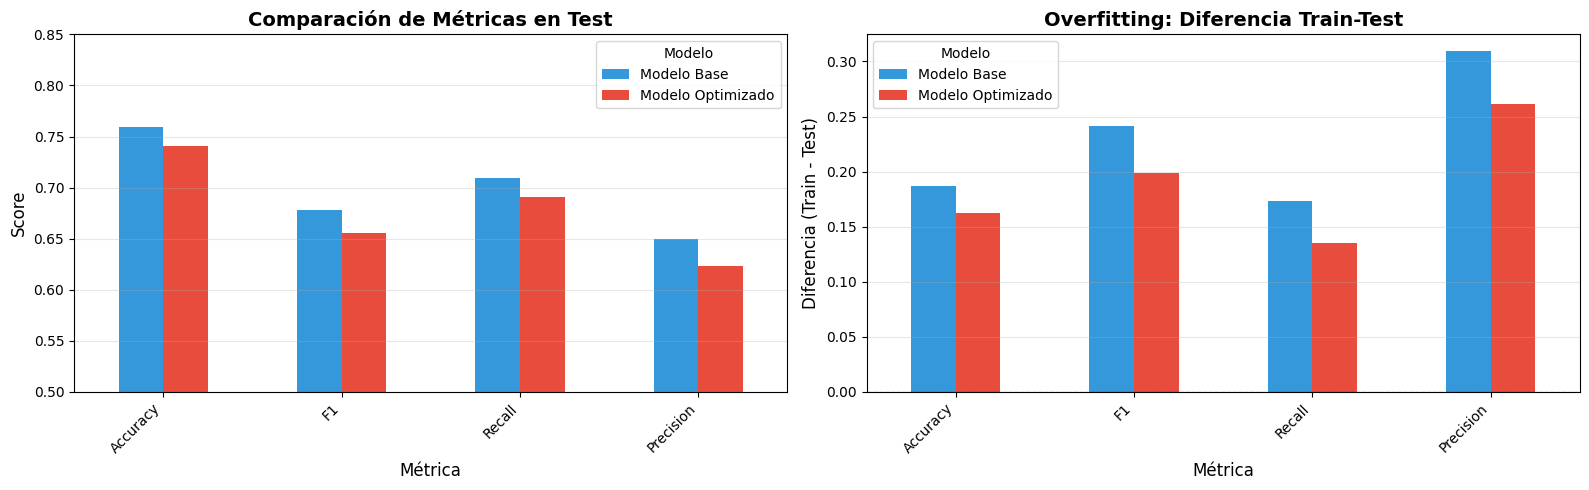

In [9]:
# Visualización de la comparación
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico 1: Comparación de métricas en Test
comparison_test = pd.DataFrame({
    'Modelo Base': base_metrics.loc['Test', ['Accuracy', 'F1', 'Recall', 'Precision']],
    'Modelo Optimizado': best_metrics.loc['Test', ['Accuracy', 'F1', 'Recall', 'Precision']]
})

comparison_test.plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('Comparación de Métricas en Test', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_xlabel('Métrica', fontsize=12)
axes[0].legend(title='Modelo', fontsize=10)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_ylim([0.5, 0.85])

# Gráfico 2: Comparación del Overfitting (Diferencia Train-Test)
comparison_diff = pd.DataFrame({
    'Modelo Base': base_metrics.loc['Diferencia', ['Accuracy', 'F1', 'Recall', 'Precision']],
    'Modelo Optimizado': best_metrics.loc['Diferencia', ['Accuracy', 'F1', 'Recall', 'Precision']]
})

comparison_diff.plot(kind='bar', ax=axes[1], color=['#3498db', '#e74c3c'])
axes[1].set_title('Overfitting: Diferencia Train-Test', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Diferencia (Train - Test)', fontsize=12)
axes[1].set_xlabel('Métrica', fontsize=12)
axes[1].legend(title='Modelo', fontsize=10)
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

# 4.1 Guardamos el modelo

In [10]:
# Guardar el modelo base (mejor desempeño)
model_path = '/workspaces/carlos060495-intro-ml/models/gradient_boosting_diabetes.pkl'

with open(model_path, 'wb') as file:
    pickle.dump(model, file)

print("✅ Modelo base guardado exitosamente")
print(f"📁 Ubicación: {model_path}")
print("\n📊 Hiperparámetros del modelo guardado:")
print("=" * 50)
print(f"n_estimators: {model.n_estimators}")
print(f"learning_rate: {model.learning_rate}")
print(f"max_depth: {model.max_depth}")
print(f"min_samples_leaf: {model.min_samples_leaf}")
print("=" * 50)

✅ Modelo base guardado exitosamente
📁 Ubicación: /workspaces/carlos060495-intro-ml/models/gradient_boosting_diabetes.pkl

📊 Hiperparámetros del modelo guardado:
n_estimators: 100
learning_rate: 0.1
max_depth: 3
min_samples_leaf: 5


# 5.1 Comparacion de modelos

In [11]:


# Cargar los modelos guardados
models_dir = '/workspaces/carlos060495-intro-ml/models'

# Función para cargar modelos con ambos métodos (pickle y joblib)
def load_model_safe(filepath, model_name):
    try:
        # Intentar con joblib primero (más común en sklearn)
        model = joblib.load(filepath)
        print(f"✅ {model_name} cargado exitosamente (joblib)")
        return model
    except:
        try:
            # Intentar con pickle
            with open(filepath, 'rb') as file:
                model = pickle.load(file)
            print(f"✅ {model_name} cargado exitosamente (pickle)")
            return model
        except Exception as e:
            print(f"❌ Error al cargar {model_name}: {e}")
            return None

# Cargar Decision Tree
dt_model = load_model_safe(os.path.join(models_dir, 'decision_tree_diabetes.pkl'), 'Decision Tree')

# Cargar Random Forest
rf_model = load_model_safe(os.path.join(models_dir, 'random_forest_diabetes.pkl'), 'Random Forest')

# Cargar Gradient Boosting
gb_model = load_model_safe(os.path.join(models_dir, 'gradient_boosting_diabetes.pkl'), 'Gradient Boosting')

# Verificar qué modelos se cargaron correctamente
print("\n📊 Resumen de modelos cargados:")
print("=" * 50)
if dt_model:
    print(f"✓ Decision Tree: {type(dt_model).__name__}")
if rf_model:
    print(f"✓ Random Forest: {type(rf_model).__name__}")
if gb_model:
    print(f"✓ Gradient Boosting: {type(gb_model).__name__}")
print("=" * 50)

✅ Decision Tree cargado exitosamente (joblib)
✅ Random Forest cargado exitosamente (joblib)
✅ Gradient Boosting cargado exitosamente (joblib)

📊 Resumen de modelos cargados:
✓ Decision Tree: DecisionTreeClassifier
✓ Random Forest: RandomForestClassifier
✓ Gradient Boosting: GradientBoostingClassifier


In [12]:
# Hacer predicciones con cada modelo
print("🔮 Realizando predicciones con los 3 modelos...")
print("=" * 60)

# Decision Tree
dt_pred_train = dt_model.predict(X_train)
dt_pred_test = dt_model.predict(X_test)
dt_metrics = get_metrics(y_train, y_test, dt_pred_train, dt_pred_test)

# Random Forest
rf_pred_train = rf_model.predict(X_train)
rf_pred_test = rf_model.predict(X_test)
rf_metrics = get_metrics(y_train, y_test, rf_pred_train, rf_pred_test)

# Gradient Boosting
gb_pred_train = gb_model.predict(X_train)
gb_pred_test = gb_model.predict(X_test)
gb_metrics = get_metrics(y_train, y_test, gb_pred_train, gb_pred_test)

print("✅ Predicciones completadas para los 3 modelos\n")

# Crear tabla comparativa con métricas de TEST
comparison_df = pd.DataFrame({
    'Decision Tree': dt_metrics.loc['Test'],
    'Random Forest': rf_metrics.loc['Test'],
    'Gradient Boosting': gb_metrics.loc['Test']
}).T

print("📊 COMPARACIÓN DE MODELOS - Métricas en TEST")
print("=" * 80)
print(comparison_df)
print("=" * 80)

🔮 Realizando predicciones con los 3 modelos...
✅ Predicciones completadas para los 3 modelos

📊 COMPARACIÓN DE MODELOS - Métricas en TEST
                   Accuracy        F1       AUC  Precision    Recall  \
Decision Tree       0.74026  0.682540  0.749495   0.605634  0.781818   
Random Forest       0.75974  0.660550  0.736364   0.666667  0.654545   
Gradient Boosting   0.75974  0.678261  0.748485   0.650000  0.709091   

                   Specificity  
Decision Tree         0.717172  
Random Forest         0.818182  
Gradient Boosting     0.787879  


In [14]:
# Análisis de precisión predictiva
print("\n🎯 ANÁLISIS DE PRECISIÓN PREDICTIVA")
print("=" * 80)

# Encontrar el modelo con mayor y menor precisión (Accuracy)
best_accuracy_model = comparison_df['Accuracy'].idxmax()
worst_accuracy_model = comparison_df['Accuracy'].idxmin()
best_accuracy_value = comparison_df['Accuracy'].max()
worst_accuracy_value = comparison_df['Accuracy'].min()

print(f"\n📈 Modelo con MAYOR precisión: {best_accuracy_model}")
print(f"   Accuracy: {best_accuracy_value:.4f} ({best_accuracy_value*100:.2f}%)")

print(f"\n📉 Modelo con MENOR precisión: {worst_accuracy_model}")
print(f"   Accuracy: {worst_accuracy_value:.4f} ({worst_accuracy_value*100:.2f}%)")

# Análisis por clase (Precision para cada clase)
print(f"\n🔍 Análisis de precisión por clase:")
print(f"\nPrecision (Clase Positiva - Diabetes):")
for model in comparison_df.index:
    print(f"  {model:20s}: {comparison_df.loc[model, 'Precision']:.4f}")

print(f"\nSpecificity (Clase Negativa - No Diabetes):")
for model in comparison_df.index:
    print(f"  {model:20s}: {comparison_df.loc[model, 'Specificity']:.4f}")

# Modelo recomendado basado en F1-Score (balance entre precision y recall)
best_f1_model = comparison_df['F1'].idxmax()
best_f1_value = comparison_df['F1'].max()

print("\n" + "=" * 80)
print("🏆 MODELO RECOMENDADO")
print("=" * 80)
print(f"\nModelo seleccionado: {best_f1_model}")
print(f"F1-Score: {best_f1_value:.4f}")
print(f"\n💡 Justificación:")
print(f"   • El {best_f1_model} presenta el mejor balance entre precisión y recall (F1-Score)")
print(f"   • Accuracy: {comparison_df.loc[best_f1_model, 'Accuracy']:.4f}")
print(f"   • Precision: {comparison_df.loc[best_f1_model, 'Precision']:.4f} (buen rendimiento detectando diabetes)")
print(f"   • Recall: {comparison_df.loc[best_f1_model, 'Recall']:.4f} (captura bien los casos positivos)")
print(f"   • AUC: {comparison_df.loc[best_f1_model, 'AUC']:.4f} (excelente capacidad discriminativa)")
print("=" * 80)


🎯 ANÁLISIS DE PRECISIÓN PREDICTIVA

📈 Modelo con MAYOR precisión: Random Forest
   Accuracy: 0.7597 (75.97%)

📉 Modelo con MENOR precisión: Decision Tree
   Accuracy: 0.7403 (74.03%)

🔍 Análisis de precisión por clase:

Precision (Clase Positiva - Diabetes):
  Decision Tree       : 0.6056
  Random Forest       : 0.6667
  Gradient Boosting   : 0.6500

Specificity (Clase Negativa - No Diabetes):
  Decision Tree       : 0.7172
  Random Forest       : 0.8182
  Gradient Boosting   : 0.7879

🏆 MODELO RECOMENDADO

Modelo seleccionado: Decision Tree
F1-Score: 0.6825

💡 Justificación:
   • El Decision Tree presenta el mejor balance entre precisión y recall (F1-Score)
   • Accuracy: 0.7403
   • Precision: 0.6056 (buen rendimiento detectando diabetes)
   • Recall: 0.7818 (captura bien los casos positivos)
   • AUC: 0.7495 (excelente capacidad discriminativa)
